In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras import optimizers

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

Load data

In [ ]:
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Split the dataset into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(f"X_train shape: {X_train.shape}")
#print(f"y_train shape: {y_train.shape}")
#print(f"X_val shape: {X_val.shape}")
#print(f"y_val shape: {y_val.shape}")


170498071/170498071 [==============================] - 2s 0us/step
X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


visualization

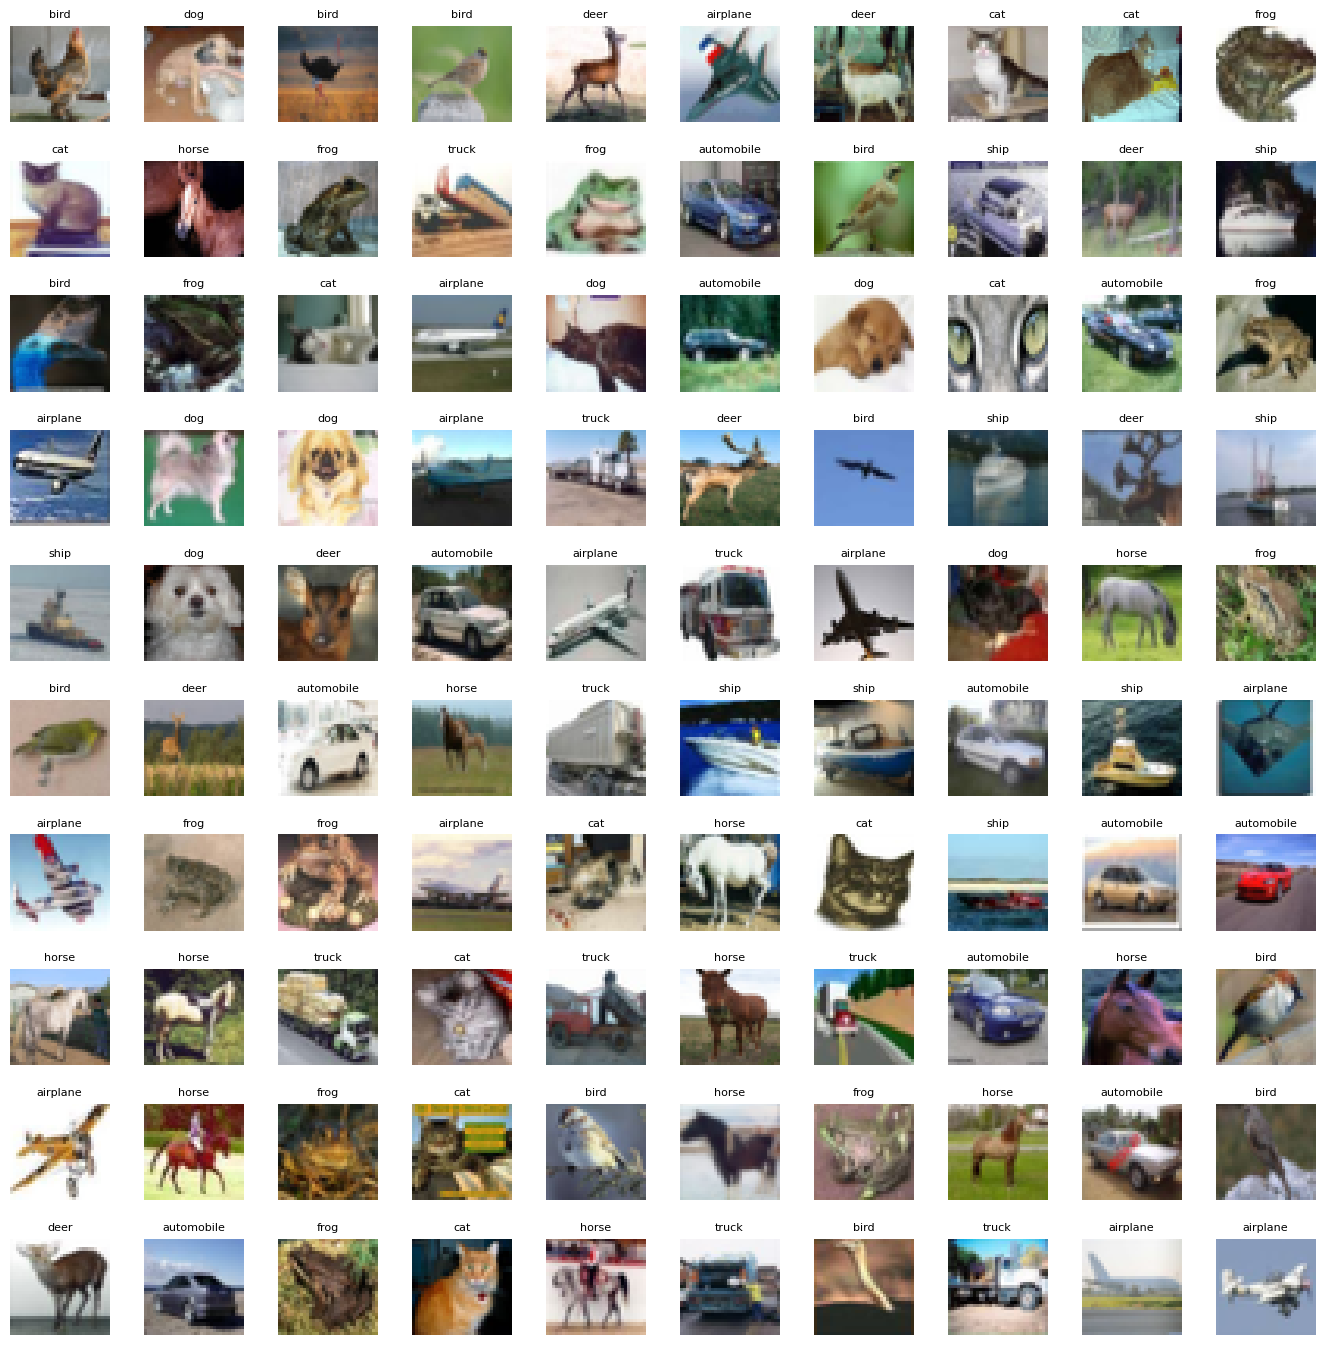

In [ ]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

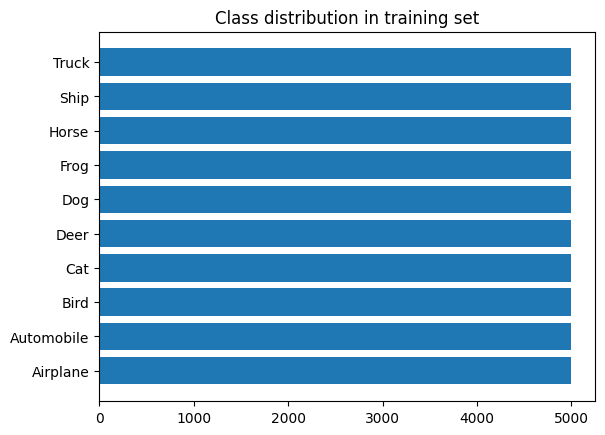

In [ ]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')


Text(0.5, 1.0, 'Class distribution in testing set')

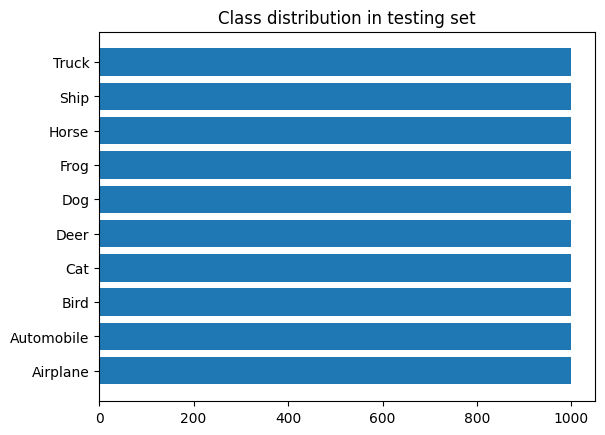

In [ ]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

Data Perpocessing

In [ ]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

#y_bird_train = to_categorical(y_train, 10)
#y_bird_test = to_categorical(y_test, 10)

In [ ]:
y_cat_train


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

AlexNet

In [ ]:
from keras import backend as K
from keras.layers import Layer

class LRN(Layer):
    def __init__(self, alpha=1e-4, beta=0.75, k=2, n=5, **kwargs):
        self.alpha = alpha
        self.beta = beta
        self.k = k
        self.n = n
        super(LRN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.shape = input_shape
        super(LRN, self).build(input_shape)

    def call(self, x, mask=None):
        squared = K.square(x)
        pooled = K.pool2d(squared, (self.n, self.n), strides=(1, 1), padding='same', pool_mode='avg')
        summed = K.sum(pooled, axis=1, keepdims=True)
        averaged = self.alpha * K.repeat_elements(summed, self.shape[1], axis=1)
        denom = K.pow(self.k + averaged, self.beta)
        return x / denom

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adam, Adamax, Adadelta, Adafactor, Ftrl, Nadam, AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical


INPUT_SHAPE = (32, 32, 3)  # input shape is 32x32 pixels with 3 color channels
NUM_CLASSES = 10  #  10 output classes

def create_model():
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(96, (3, 3), input_shape=INPUT_SHAPE, strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(BatchNormalization())

    # 2nd Convolutional Layer
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(BatchNormalization())

    # 3rd Convolutional Layer
    model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # 4th Convolutional Layer
    model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # 5th Convolutional Layer
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(BatchNormalization())

    model.add(Flatten())

    # 1st Dense Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # 2nd Dense Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Output Layer
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))
   # model.add(Dense(10, activation='softmax'))  # 10 is the number of classes

    # Compile the model for optimizer comparison
    sgd = SGD(learning_rate=0.01, momentum=0.9)


    METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=METRICS)

    return model

model = create_model()
model.summary()

   # List of optimizers to compare
#optimizers = [SGD(), RMSprop(), Adagrad(), Adam(), AdamW(), Adadelta(), Adagrad(), Adamax(), Adafactor(), Nadam(), Ftrl()]


#results = {}  # Store results for each optimizer

# Iterate through each optimizer
#METRICS = [
 #   'accuracy',
 #   tf.keras.metrics.Precision(name='precision'),
#    tf.keras.metrics.Recall(name='recall')
#]
#y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
#y_test = to_categorical(y_test, num_classes=NUM_CLASSES)
#for optimizer in optimizers:
 #   model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=METRICS)
  #  history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

 #   test_results = model.evaluate(X_test, y_test)
  #  print(f"Optimizer: {optimizer.__class__.__name__}")
   # print(f"Test accuracy: {test_results[1]}")
   # print(f"Test precision: {test_results[2]}")
    #print(f"Test recall: {test_results[3]}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 96)        2688      
                                                                 
 activation (Activation)     (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 16, 16, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       221440    
                                                                 
 activation_1 (Activation)   (None, 16, 16, 256)       0

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

r = model.fit(train_generator,
              epochs=60,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test),
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/60
1562/1562 [==============================] - 65s 29ms/step - loss: 1.8518 - accuracy: 0.4211 - precision: 0.5039 - recall: 0.3282 - val_loss: 1.4893 - val_accuracy: 0.5329 - val_precision: 0.6154 - val_recall: 0.4420
Epoch 2/60
1562/1562 [==============================] - 45s 29ms/step - loss: 1.3177 - accuracy: 0.5753 - precision: 0.6563 - recall: 0.4973 - val_loss: 1.9296 - val_accuracy: 0.4451 - val_precision: 0.4867 - val_recall: 0.3901
Epoch 3/60
1562/1562 [==============================] - 46s 29ms/step - loss: 1.1315 - accuracy: 0.6354 - precision: 0.7130 - recall: 0.5683 - val_loss: 0.9510 - val_accuracy: 0.6877 - val_precision: 0.7717 - val_recall: 0.6189
Epoch 4/60
1562/1562 [==============================] - 47s 30ms/step - loss: 1.0721 - accuracy: 0.6571 - precision: 0.7354 - recall: 0.5916 - val_loss: 1.2320 - val_accuracy: 0.6398 - val_precision: 0.7191 - val_recall: 0.5745
Epoch 5/60
1562/1562 [==============================] - 46s 29ms/step - loss: 1.0210 - a

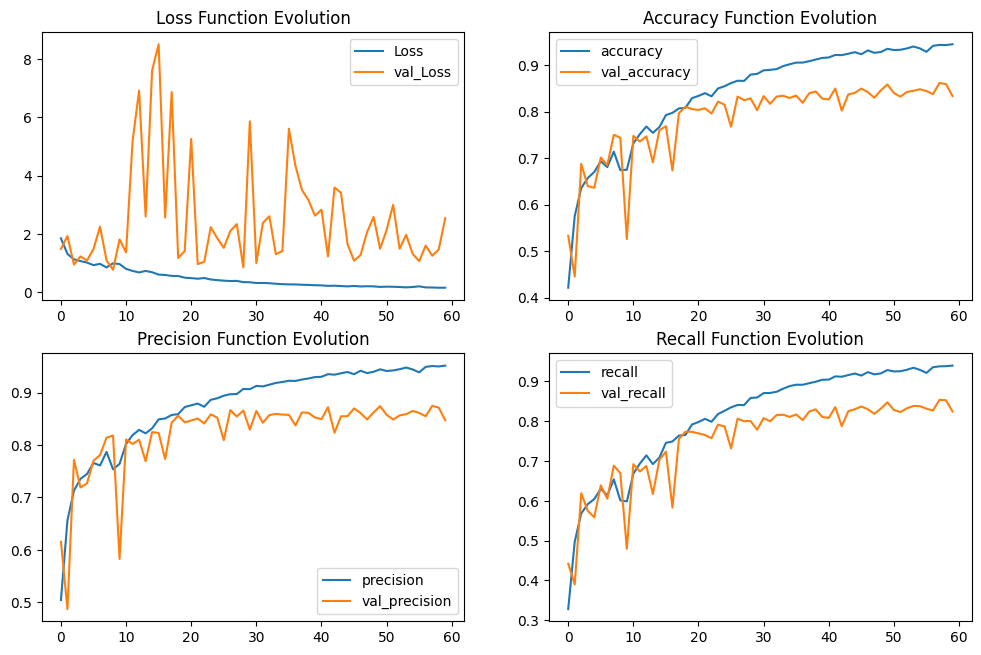

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()


In [ ]:
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_cat_test: {y_cat_test.shape}")
print(f"Sample y_test value: {y_test[0]}")
print(f"Sample y_cat_test value: {y_cat_test[0]}")


Shape of X_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)
Shape of y_cat_test: (10000, 10)
Sample y_test value: [3]
Sample y_cat_test value: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


313/313 [==============================] - 2s 5ms/step - loss: 2.5418 - accuracy: 0.8336 - precision: 0.8474 - recall: 0.8240
Test Accuracy : 83.36%
313/313 [==============================] - 1s 3ms/step


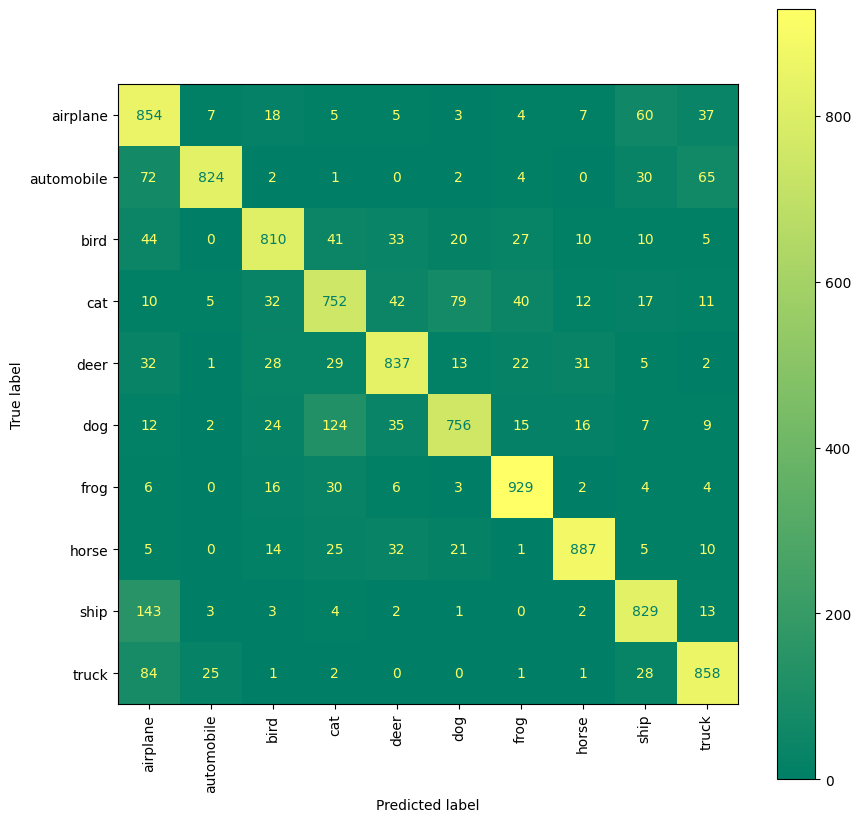

In [ ]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [ ]:
from tensorflow.keras.utils import to_categorical

# Model Summary
model.summary()

# Ensure the label shape matches the prediction shape
# For example, if the model output is one-hot encoded:
# If the labels are in integer format
if len(y_cat_test.shape) > 1:  # Indicates one-hot encoding
    # Convert labels to categorical if not in one-hot encoded format
    y_test = np.argmax(y_cat_test, axis=1)
else:
    # One-hot encode labels if model output is categorical
    y_cat_test = to_categorical(y_test, num_classes=num_classes)  # num_classes should be defined


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 96)        2688      
                                                                 
 activation (Activation)     (None, 32, 32, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 96)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 16, 16, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 256)       221440    
                                                                 
 activation_1 (Activation)   (None, 16, 16, 256)       0

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.85      0.76      1000
           1       0.95      0.82      0.88      1000
           2       0.85      0.81      0.83      1000
           3       0.74      0.75      0.75      1000
           4       0.84      0.84      0.84      1000
           5       0.84      0.76      0.80      1000
           6       0.89      0.93      0.91      1000
           7       0.92      0.89      0.90      1000
           8       0.83      0.83      0.83      1000
           9       0.85      0.86      0.85      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



Test image

 Image 100 is 4
1/1 [==============================] - 0s 103ms/step
The model predict that image 100 is 4


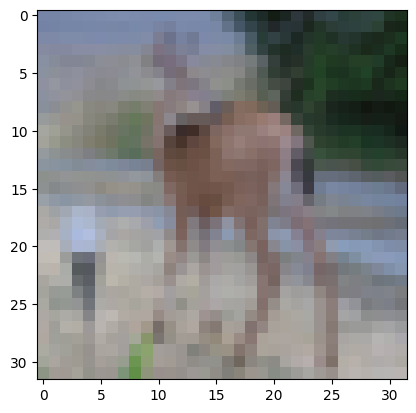

In [ ]:
my_image = X_test[100]
plt.imshow(my_image)

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {pred_100}")

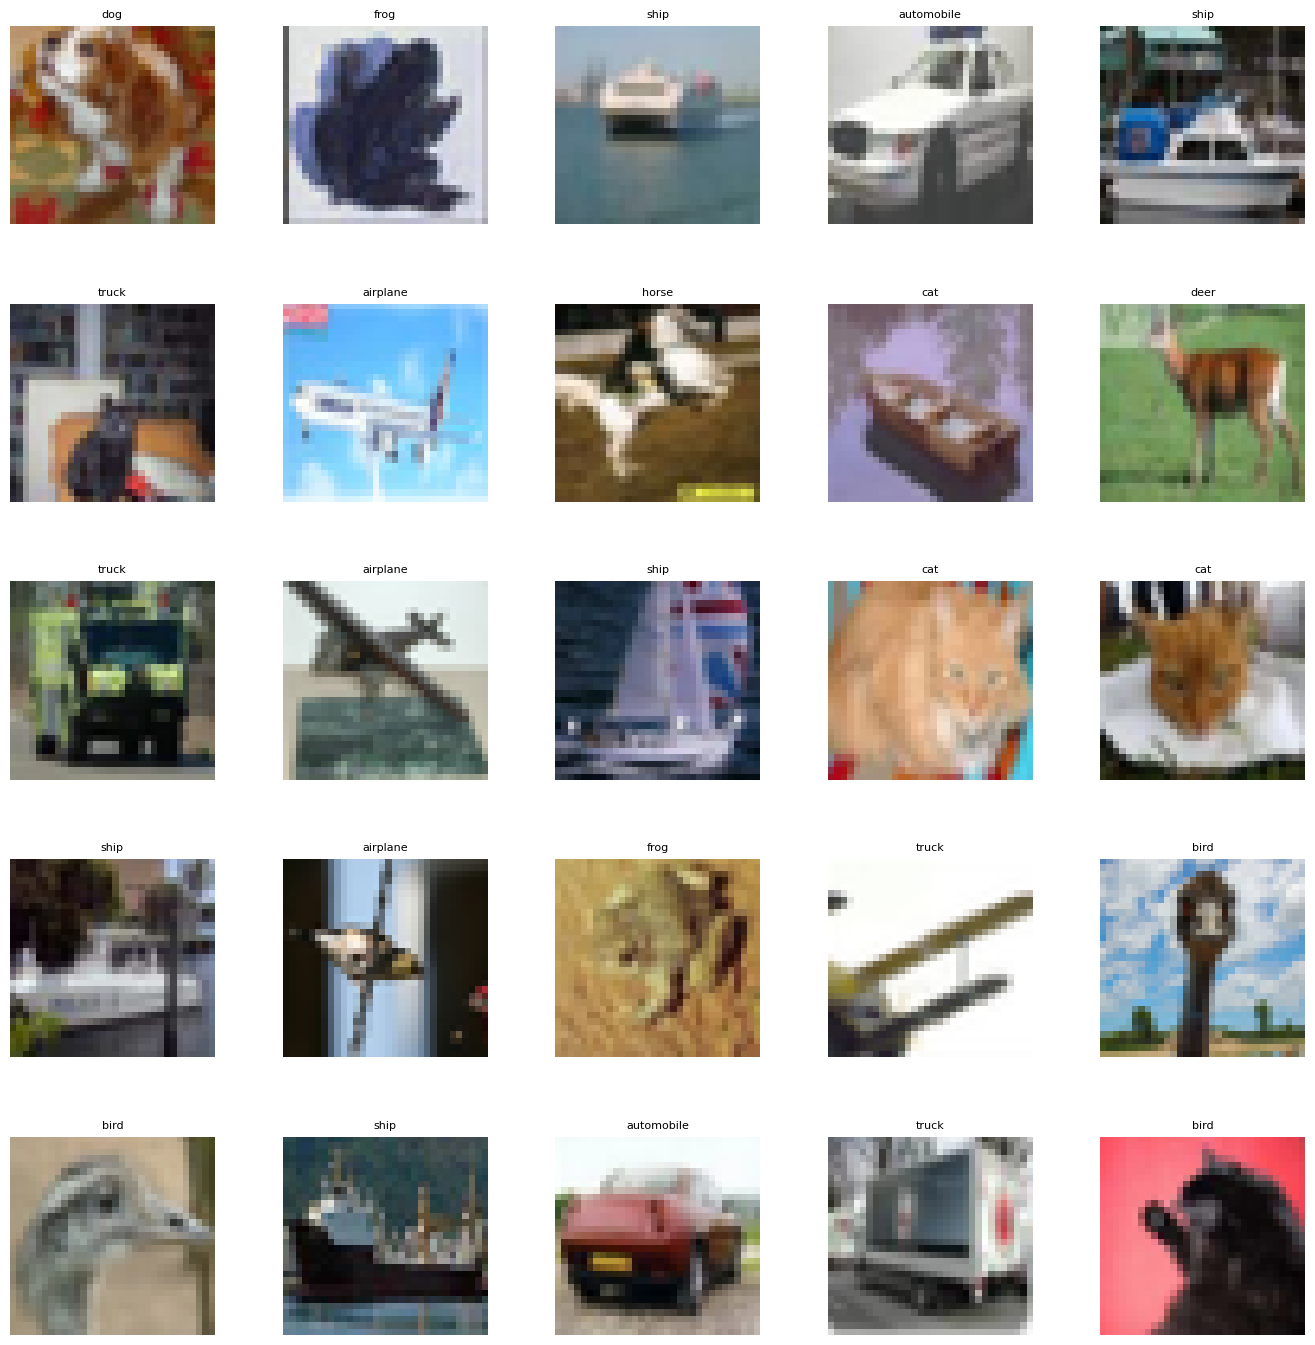

In [ ]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})",
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 [==============================] - 1s 3ms/step


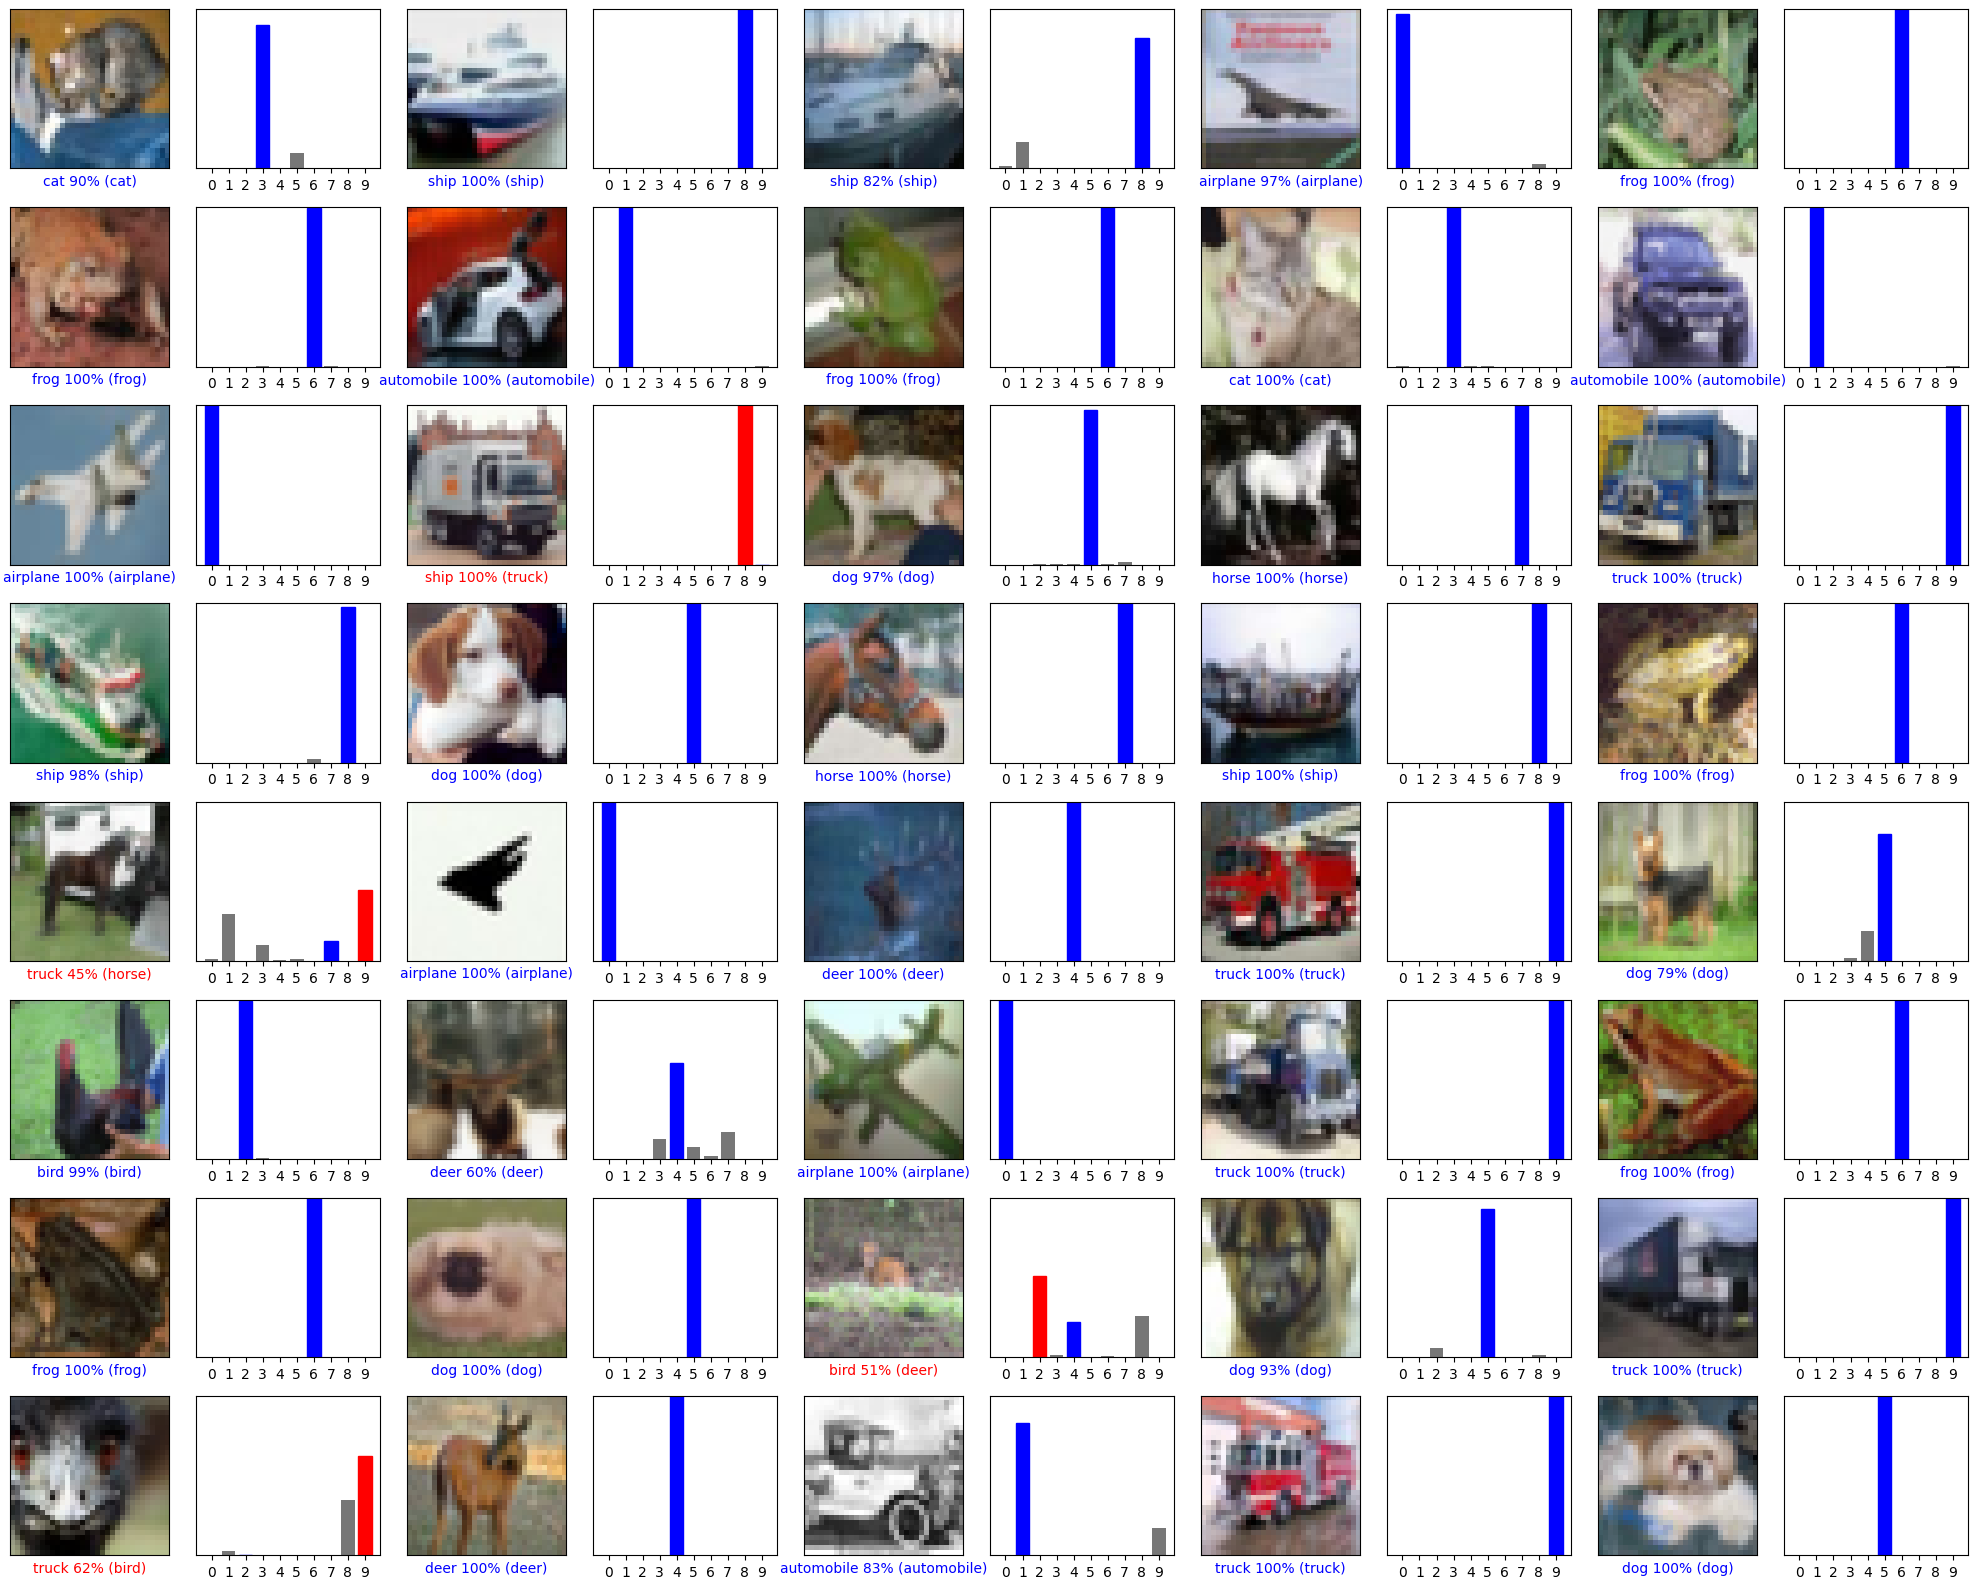

In [ ]:
predictions = model.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

Save CNN

In [ ]:
from tensorflow.keras.models import load_model

model.save('alexNet-50Epochs.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Cross Fold validation Kfold

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
import numpy as np
from tensorflow.keras.datasets import cifar10

num_folds = 5
input_shape = (32, 32, 3)
no_classes = 10
loss_function = 'sparse_categorical_crossentropy'
optimizer = LegacyAdam()
no_epochs = 10
batch_size = 32
verbosity = 1

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

kfold = KFold(n_splits=num_folds, shuffle=True)

fold_no = 1
for train, test in kfold.split(X_train, y_train):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(no_classes, activation='softmax'))

    model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])

    print('Training for fold ', fold_no)

    history = model.fit(X_train[train], y_train[train], batch_size=batch_size, epochs=no_epochs, verbose=verbosity)

    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print('Score for fold ', fold_no)
    print(model.metrics_names[0], scores[0])
    print(model.metrics_names[1], scores[1]*100)
    fold_no += 1



Training for fold  1
Epoch 1/10
1250/1250 [==============================] - 5s 3ms/step - loss: 1.4645 - accuracy: 0.4656
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0690 - accuracy: 0.6198
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.8926 - accuracy: 0.6851
Epoch 4/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7576 - accuracy: 0.7351
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.6419 - accuracy: 0.7761
Epoch 6/10
1250/1250 [==============================] - 4s 4ms/step - loss: 0.5312 - accuracy: 0.8134
Epoch 7/10
1250/1250 [==============================] - 4s 3ms/step - loss: 0.4367 - accuracy: 0.8459
Epoch 8/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.3465 - accuracy: 0.8785
Epoch 9/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2770 - accuracy: 0.9016
Epoch 10/10
1250/1250 [==============================] - 4s 3